In [ ]:
%cd /content/drive/MyDrive/
# raw_data is imported from global config
root_dir='/content/drive/MyDrive/'  # ChangeThis
result_dir=root_dir+'grasp/TSception/result_test_dropout/'

/content/drive/MyDrive


In [ ]:
import sys, importlib
#importlib.reload(sys.modules['grasp.config'])
from grasp.config import data_dir
# orveride the data_dir in config file
#data_dir='/content/drive/MyDrive/data/' # googleDrive

In [ ]:
data_dir

'/content/drive/MyDrive/data/'

In [ ]:
! pip install mne==0.19.2;
! pip install torch;

     |████████████████████████████████| 6.4MB 7.0MB/s 


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from grasp.TSception.utils import regulization
from grasp.utils import SEEGDataset,SEEGDataset1
from grasp.TSception.Models import TSception

# load the data: regression to target force derivative
from grasp.utils import rawData2
from grasp.config import activeChannels, root_dir


In [ ]:
# reload function
import sys, importlib
importlib.reload(sys.modules['grasp.TSception.Models'])
importlib.reload(sys.modules['grasp.utils'])
from grasp.TSception.Models import TSception,TSception2
from grasp.utils import rawData2

In [ ]:
# import from another folder
import sys
sys.path.insert(1, '/content/drive/MyDrive/examples')
from IMV_LSTM.networks import IMVTensorLSTM

In [ ]:
data_dir

'/content/drive/MyDrive/data/'

In [ ]:
import inspect as i
import sys
#sys.stdout.write(i.getsource(rawData2));

In [ ]:
enable_cuda = torch.cuda.is_available()
print('GPU computing: ', enable_cuda)

GPU computing:  True


In [ ]:
%%capture
# suppress the output
sampling_rate=1000
#traindata, valdata, testdata = rawData2('raw',activeChannels,move2=False)  # (chns, 15000/15001, 118) (channels, time, trials)
traindata, valdata, testdata = rawData2('band','all',move2=True)
traindata = traindata.transpose(2, 0, 1)  # (118, 20, 15000) (trials,channels,  time)
valdata = valdata.transpose(2, 0, 1) # (8, 20, 15000)
testdata = testdata.transpose(2, 0, 1)  # (8, 20, 15000)
trainx, trainy = traindata[:, :-2, :], traindata[:, -2, :] #-2 is real force, -1 is target
valx, valy = valdata[:, :-2, :], valdata[:, -2, :]
testx, testy = testdata[:, -2, :], testdata[:, -2, :]


In [ ]:
chnNum=trainx.shape[1]
learning_rate=0.002
epochs=100
step=50 #ms
T=1000 #ms
totalLen=trainx.shape[2] #ms
batch_size=int((totalLen-T)/step) # 280
num_T = 3 # (6 conv2d layers) * ( 3 kernel each layer)
num_S = 3
hidden_size=222
dropout=0.2
Lambda = 1e-6

dataset_train = SEEGDataset1(trainx, trainy,T,step)
dataset_val = SEEGDataset1(valx, valy,T,step)
dataset_test = SEEGDataset1(testx, testy,T,step)

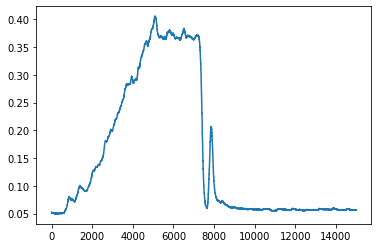

In [ ]:
trainy.shape
plt.plot(trainy[0,:])

In [ ]:
train_loader = DataLoader(dataset=dataset_train, batch_size=1, shuffle=True, pin_memory=False)
val_loader = DataLoader(dataset=dataset_val, batch_size=1, pin_memory=False)
test_loader = DataLoader(dataset=dataset_test, batch_size=1, pin_memory=False)

In [ ]:
# __init__(self,input_size, sampling_rate, num_T, num_S, hiden, dropout_rate)
net = TSception2(chnNum,sampling_rate, num_T, num_S,batch_size).float()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
if(enable_cuda):
	net.cuda()
 
#checkpoint = torch.load(result_dir+'checkpoint95.pth')
#net.load_state_dict(checkpoint['state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
debugg=False
debugg=True
for epoch in range(96,200):
    print("------ epoch " + str(epoch) + " -----")
    net.train()

    loss_epoch=0
    #trial=0
    for trial, (trainx, trainy) in enumerate(train_loader): # ([1, 15000, 19]), ([1, 15000])
        #trainy[0,-1]+=0.05
        if debugg==True: # just test one trial
            if trial == 1:
                break
                pass
        optimizer.zero_grad()
        
        if (enable_cuda):
            x= trainx.float().cuda()
            target = trainy.float().cuda()
        y_pred = net(x)
        #target = torch.from_numpy(target)

        # regularization
        loss1 = criterion(y_pred, target.float())
        loss2 = regulization(net, Lambda)
        #loss3 = y_pred.cpu().detach().numpy()
        #loss3 = np.std(np.diff(loss3.reshape(-1)))
        loss=loss1+loss2 #+loss3*0.001
        loss.backward()
        optimizer.step()

        ls=loss1.item()
        loss_epoch+=ls
        with open(result_dir+ "trainlose.txt", "a") as f:
            f.write(str(loss1) + "\n")
    print(""+str(epoch)+" loss:"+str(loss_epoch/(trial+1))+".")
    if epoch % 1 ==0:
        net.eval()
        print("Validating...")
        with torch.no_grad():
            vpredAll = []
            vtargetAll = []
            for trial, (vx, vtarget) in enumerate(val_loader):  # ([1, 15000, 19]), ([1, 15000])                
                if (enable_cuda):
                    vx= vx.float().cuda()
                    vtarget = vtarget.float().cuda()
                y_pred = net(vx)
                y_pred=y_pred.squeeze().cpu().detach().numpy()
                vtarget=vtarget.squeeze().numpy()
                vpredAll.append(y_pred)
                vtargetAll.append(vtarget)

                
                loss3 = criterion(y_pred, vtarget.float())
                with open(result_dir+"testlose.txt", "a") as f:
                    f.write(str(loss3) + "\n")


        vpredAll = np.concatenate(vpredAll,axis=0)
        vtargetAll = np.concatenate(vtargetAll, axis=0)

        fig, ax = plt.subplots(figsize=(6, 3))
        plt.ion()
        ax.clear()
        ax.plot(vtargetAll, label="True", linewidth=1)
        ax.plot(vpredAll, label='Predicted - Test', linewidth=1)
        ax.legend(loc='upper left')
        figname = result_dir+'prediction' + str(epoch) + '.png'
        fig.savefig(figname)
        plt.close(fig)
    if epoch % 5==0:
        state = {
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        savepath = result_dir+'checkpoint'+str(epoch)+'.pth'
        torch.save(state, savepath)


------ epoch 96 -----


ValueError: ignored